In [1]:
import os
from os.path import join
import sys
# from cStringIO import StringIO
import contextlib

import time
import numpy as np
from nipy.algorithms.registration import HistogramRegistration, Rigid
import nibabel as nib


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import io

In [3]:
# load an example functional image
img = nib.load('tests/GE_func_s1925.nii.gz')

In [4]:
img.get_data().shape

(64, 64, 18, 60)

In [5]:
# create a reference volume and a test volume
affine = img.affine

refVol = img.get_data()[:,:,:,0]
refVol = nib.Nifti1Image(refVol, affine)

In [6]:
affine

array([[  2.99403310e+00,  -1.83411002e-01,  -5.83411753e-02,
         -8.58351822e+01],
       [  1.56465605e-01,   2.81301904e+00,  -1.30558825e+00,
         -5.56155281e+01],
       [  1.06205396e-01,   1.02629399e+00,   3.56818247e+00,
         -8.16833649e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

## estimate motion params between each timepoint and the reference vol
build a function that can be computed on each volume and will return the transformation between 
the current volume and the reference volume. This will allow you to tweak motion estimate parameters
in a way to find the fasted estimate

In [48]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.StringIO()
    yield
    sys.stdout = save_stdout


def estimateMotion(vol, refVol, T_estimate):
    """
    input vols should be nibabel Nifti1 images
    T_estimate is a transformation matrix to serve as a starting point for 
    the optimization. T_estimate gets changed in place
    """
    reg = HistogramRegistration(vol, refVol, interp='tri', from_bins=256)
    T = reg.optimize(T_estimate)

    return T

def rmsDeviation(T1, T2, R=50):
    """
    compute the RMS deviation between the two supplied transformations.
    """
    
    diffMatrix = T1.as_affine().dot(np.linalg.inv(T2.as_affine())) - np.eye(4)
    
    # decompose into A and t components
    A = diffMatrix[:3, :3]
    t = diffMatrix[:3, 3]
    
    # volume center assumed to be at 0,0,0 in world space
    center = np.zeros(3)
    t += A.dot(center)
    
    # compute RMS error (aka deviation error between transforms)
    rms = np.sqrt((1/5) * R**2 * A.T.dot(A).trace() + t.T.dot(t))
    
    return rms
    
    
    

In [49]:
prevEstimate = Rigid(np.eye(4))
ref_T = Rigid(np.eye(4))

rmsRef = []
rmsPrev = []

refVol = img.get_data()[:,:,:,4]
refVol = nib.Nifti1Image(refVol, affine)

# loop over each volume
for volIdx in range(img.shape[3]):
    thisVol = img.get_data()[:,:,:,volIdx]
    thisVol = nib.Nifti1Image(thisVol, affine)

    # calculate motion
    startTime = time.time()
    with nostdout():
        newT = estimateMotion(thisVol, refVol, prevEstimate.copy())

    # compute RMS to ref
    rms_ref = rmsDeviation(ref_T, newT)
    rmsRef.append(rms_ref)
    print("RMS (ref): {}".format(rms_ref))

    # compute RMS to prev
    rms_prev = rmsDeviation(prevEstimate, newT)
    rmsPrev.append(rms_prev)
    print("RMS (prev): {}".format(rms_prev))

    # get the realignment parameters:
    rot_x, rot_y, rot_z = np.rad2deg(newT.rotation)
    trans_x, trans_y, trans_z = newT.translation


    # print time
    endTime = time.time()-startTime
    #print('vol {} took: {}ms'.format(volIdx, endTime*1000))
    times.append(endTime)

    prevEstimate = newT

print('Average Time: {}'.format(np.mean(times)))


RMS (ref): 0.258494275373785
RMS (prev): 0.258494275373785
RMS (ref): 0.0827595458994726
RMS (prev): 0.20593361721804235
RMS (ref): 0.01708063566277052
RMS (prev): 0.08873860258912275
RMS (ref): 0.10475264446498242
RMS (prev): 0.11010807312944787
RMS (ref): 0.04891551660703798
RMS (prev): 0.11591817739894518
RMS (ref): 0.03770848798762912
RMS (prev): 0.07147623145749832
RMS (ref): 0.1474091019536414
RMS (prev): 0.12384337169491634
RMS (ref): 0.06622366286879573
RMS (prev): 0.14688281331437708
RMS (ref): 0.07658682362430078
RMS (prev): 0.08591246295698975
RMS (ref): 0.15133625074223497
RMS (prev): 0.0786118605451617
RMS (ref): 0.06069524620163772
RMS (prev): 0.14362748346974527
RMS (ref): 0.09499623232072858
RMS (prev): 0.10283828301376964
RMS (ref): 0.12131798329474794
RMS (prev): 0.0637335343372471
RMS (ref): 0.08679501156509589
RMS (prev): 0.11274858039487998
RMS (ref): 0.048433830883743215
RMS (prev): 0.06218879461942625
RMS (ref): 0.13939893739451048
RMS (prev): 0.11001048431083481

(0, 0.3)

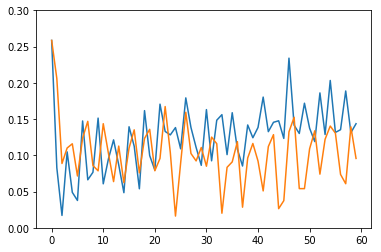

In [58]:
plt.plot(rmsRef)
plt.plot(rmsPrev)
plt.ylim(0,.3)

## Calculate RMS displacement
summarize the motion alignment parameters (rotation matrix and translation vectors) into a single displacement summary

In [9]:
# set up the reference volume
refVol = img.get_data()[:,:,:,10]
refVol = nib.Nifti1Image(refVol, affine)

# set up the test volume
testVol = img.get_data()[:,:,:,15]
testVol = nib.Nifti1Image(testVol, affine)

# set up the T for the reference volume
ref_T = Rigid(np.eye(4))


In [12]:
# get the motion 
test2ref_T = estimateMotion(refVol, testVol, ref_T)

Initial guess...
translation : [ 0.  0.  0.]
rotation    : [ 0.  0.  0.]

Optimizing using fmin_powell
translation : [ 0.01015284 -0.05166293  0.15908284]
rotation    : [ 0.00053716 -0.0001312   0.00019051]

crl1 = 0.968501568056

Optimization terminated successfully.
         Current function value: -0.968502
         Iterations: 1
         Function evaluations: 57


In [39]:
T1 = Rigid(np.eye(4))
T2 = test2ref_T

rms = rmsDeviation(T1, T2)
rms

0.17016207972408393